# Massively parallel programming with GPUs
adopted from: https://people.duke.edu/~ccc14/sta-663/CUDAPython.html

In [3]:
from numba import cuda
import numba
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from numpy import uint32, uint8, float32
import numpy as np

Mandelbrot created on CPU in 9.748196638989612 s


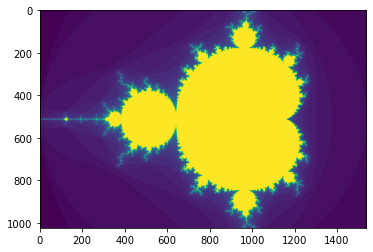

In [4]:
# pure python
def mandel(x, y, max_iters):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if z.real*z.real + z.imag*z.imag >= 4:
            return i
    return max_iters

def create_fractal(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape

    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height

    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x]  = color

gimage = np.zeros((1024, 1536), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50

start = timer()
create_fractal(xmin, xmax, ymin, ymax, gimage, iters)
dt = timer() - start

print(f"Mandelbrot created on CPU in {dt} s")
plt.imshow(gimage)

Mandelbrot created on CPU in 0.19584242599376012 s


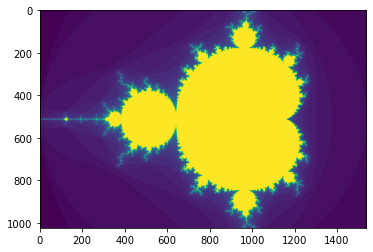

In [5]:
# cpu numba
mandel_numba = numba.jit('float32, float32, uint32')(mandel)
@numba.jit
def create_fractal_numba(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape

    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height

    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            color = mandel_numba(real, imag, iters)
            image[y, x]  = color
gimage = np.zeros((1024, 1536), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50

start = timer()
create_fractal_numba(xmin, xmax, ymin, ymax, gimage, iters)
dt = timer() - start

print(f"Mandelbrot created on CPU in {dt} s")
plt.imshow(gimage);

Mandelbrot created on GPU in 0.014491234993329272 s


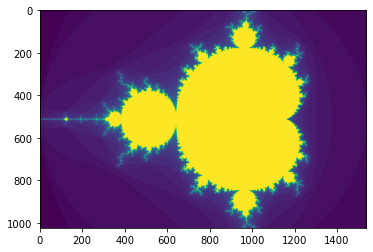

In [6]:
# gpu numba
mandel_gpu = cuda.jit('float32, float32, uint32', device=True)(mandel)
@cuda.jit('float32, float32, float32, float32, uint8[:,:], uint32')
def create_fractal_kernel(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape

    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height

    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x # stride in x
    gridY = cuda.gridDim.y * cuda.blockDim.y # stride in y

    for x in range(startX, width, gridX):
        real = xmin + x*pixel_size_x
        for y in range(startY, height, gridY):
            imag = ymin + y*pixel_size_y
            color = mandel_gpu(real, imag, iters)
            image[y, x]  = color
gimage = np.zeros((1024, 1536), dtype=np.uint8)
blockdim = (32, 8)
griddim = (32, 16)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50

start = timer()
d_image = cuda.to_device(gimage)
create_fractal_kernel[griddim, blockdim](xmin, xmax, ymin, ymax, d_image, iters)
d_image.to_host()
dt = timer() - start

print(f"Mandelbrot created on GPU in {dt} s")
plt.imshow(gimage);